# Python 世界的异步

## [1 什么是异步编程](https://blog.csdn.net/lu8000/article/details/45025987)
### 1.1 阻塞
程序未得到所需计算资源时`自己被挂起`的状态。
程序在等待某个操作完成期间，自身无法继续干别的事情，则称该程序在该操作上是阻塞的。
常见的阻塞形式有：`网络I/O阻塞`、`磁盘I/O阻塞`、`用户输入阻塞`等。
阻塞是无处不在的，包括CPU切换上下文时，所有的进程都无法真正干事情，它们也会被阻塞。（如果是多核CPU则正在执行上下文切换操作的核不可被利用。）
> 举例子： http访问、锁、等待事件、文件读写、db查询

### 1.2 非阻塞
程序在等待某操作过程中，`自身不被阻塞`，可以继续运行干别的事情，则称该程序在该操作上是非阻塞的。
非阻塞并不是在任何程序级别、任何情况下都可以存在的。
仅当程序封装的级别可以囊括独立的子程序单元时，它才可能存在非阻塞状态。
非阻塞的存在是因为阻塞存在，正因为某个操作阻塞导致的耗时与效率低下，我们才要把它变成非阻塞的。

> 总结就是遇到等待的事务是否可以继续敢别的

### 1.3 同步
不同程序单元为了完成某个任务，在执行过程中需靠某种通信方式以协调一致，称这些程序单元是同步执行的。
例如购物系统中更新商品库存，需要用“行锁”作为通信信号，让不同的更新请求强制排队顺序执行，那更新库存的操作是同步的。
简言之，`同步意味着有序`。

### .4 异步
为完成某个任务，不同程序单元之间过程中无需通信协调，也能完成任务的方式。
不相关的程序单元之间可以是异步的。
> 例如，爬虫下载网页。调度程序调用下载程序后，即可调度其他任务，而无需与该下载任务保持通信以协调行为。不同网页的下载、保存等操作都是无关的，也无需相互通知协调。这些异步操作的完成时刻并不确定。
简言之，异步意味着无序。

上文提到的“通信方式”通常是指异步和并发编程提供的同步原语，如信号量、锁、同步队列等等。我们需知道，虽然这些通信方式是为了让多个程序在一定条件下同步执行，但正因为是异步的存在，才需要这些通信方式。如果所有程序都是按序执行，其本身就是同步的，又何需这些同步信号呢？

### 1.5 并发
并发描述的是程序的组织结构。指程序要被设计成多个可独立执行的子任务。
以利用有限的计算机资源使多个任务可以被实时或近实时执行为目的。


### 1.6 并行
并行描述的是程序的执行状态。指多个任务同时被执行。
以利用富余计算资源（`多核CPU`）加速完成多个任务为目的。
并发提供了一种程序组织结构方式，让问题的解决方案可以并行执行，但并行执行不是必须的。

### 1.7 概念总结
* `并行`是为了利用多核加速多任务完成的进度

* `并发`是为了让独立的子任务都有机会被尽快执行，但不一定能加速整体进度

* `非阻`塞是为了提高程序整体执行效率

* `异步`是高效地组织非阻塞任务的方式

要支持并发，必须拆分为多任务，不同任务相对而言才有阻塞/非阻塞、同步/异步。所以，并发、异步、非阻塞三个词总是如影随形。

### 1.8 异步编程
以进程、线程、协程、函数/方法作为执行任务程序的基本单位，结合回调、事件循环、信号量等机制，以提高程序整体执行效率和并发能力的编程方式。
如果在某程序的运行时，能根据已经执行的指令准确判断它接下来要进行哪个具体操作，那它是同步程序，反之则为异步程序。（无序与有序的区别）

同步/异步、阻塞/非阻塞并非水火不容，要看讨论的程序所处的封装级别。例如购物程序在处理多个用户的浏览请求可以是异步的，而更新库存时必须是同步的。

### 1.9 异步之难(nán)
控制不住“计几”写的程序，因为其执行顺序不可预料，当下正要发生什么事件不可预料。在并行情况下更为复杂和艰难。
所以，`几乎所有的异步框架都将异步编程模型简化：一次只允许处理一个事件`。故而有关异步的讨论几乎都集中在了单线程内, 如redis 和 nginx。

如果某事件处理程序需要长时间执行，所有其他部分都会被阻塞。

所以，`一旦采取异步编程，每个异步调用必须“足够小”，不能耗时太久`。如何拆分异步任务成了难题。

程序下一步行为往往依赖上一步执行结果，如何知晓上次异步调用已完成并获取结果？
回调（Callback）成了必然选择。那又需要面临`“回调地狱”`的折磨。
同步代码改为异步代码，必然破坏代码结构。

解决问题的逻辑也要转变，不再是一条路走到黑，需要精心安排异步任务。


## 2 苦心异步为哪般
如上文所述，异步编程面临诸多难点，Python 之父亲自上阵打磨4年才使 asyncio 模块在Python 3.6中“转正”，如此苦心为什么？答案只有一个：它值得！下面我们看看为何而值得。

### 2.1 CPU的时间观

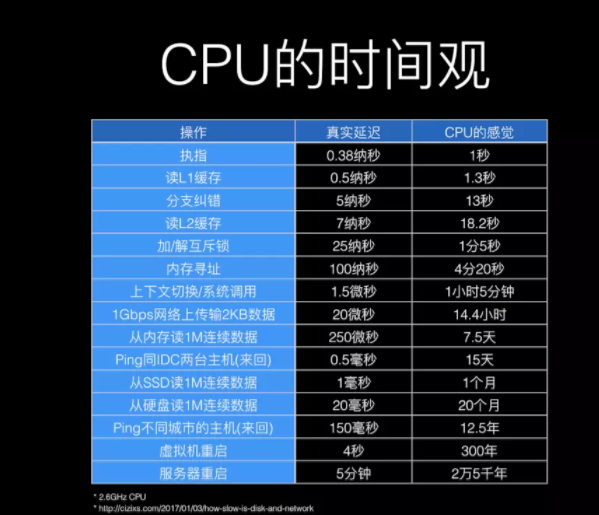

我们将一个 2.6GHz 的 CPU 拟人化，假设它执行一条命令的时间，他它感觉上过了一秒钟。CPU是计算机的处理核心，也是最宝贵的资源，如果有浪费CPU的运行时间，导致其利用率不足，那程序效率必然低下（因为实际上有资源可以使效率更高）。

如上图所示，`在千兆网上传输2KB数据，CPU感觉过了14个小时`，如果是在10M的公网上呢？那效率会低百倍！如果在这么长的一段时间内，CPU只是傻等结果而不能去干其他事情，是不是在浪费CPU的青春？

鲁迅说，浪费“CPU”的时间等于谋财害命。而凶手就是程序猿。

### 2.2 面临的问题
* 成本问题

如果一个程序不能有效利用一台计算机资源，那必然需要更多的计算机通过运行更多的程序实例来弥补需求缺口。例如我前不久主导重写的项目，使用Python异步编程，改版后由原来的7台服务器削减至3台，成本骤降57%。一台AWS m4.xlarge 型通用服务器按需付费实例一年价格约 1.2 万人民币。

* 效率问题

如果不在乎钱的消耗，那也会在意效率问题。当服务器数量堆叠到一定规模后，如果不改进软件架构和实现，加机器是徒劳，而且运维成本会骤然增加。比如别人家的电商平台支持6000单/秒支付，而自家在下单量才支撑2000单/秒，在双十一这种活动的时候，钱送上门也赚不到。

* C10k/C10M挑战

C10k（concurrently handling 10k connections）是一个在1999年被提出来的技术挑战，如何在一颗1GHz CPU，2G内存，1gbps网络环境下，让`单台服务器同时为1万个客户端提供FTP服务`。

而到了2010年后，随着硬件技术的发展，这个问题被延伸为C10M，即如何利用8核心CPU，64G内存，在10gbps的网络上保持1000万并发连接，`或是每秒钟处理100万的连接`。（两种类型的计算机资源在各自的时代都约为1200美元）

成本和效率问题是从企业经营角度讲，C10k/C10M问题则是从技术角度出发挑战软硬件极限。C10k/C10M 问题得解，成本问题和效率问题迎刃而解。

### 2.3 解决方案
《约束理论与企业优化》中指出：`“除了瓶颈之外，任何改进都是幻觉。”`

CPU告诉我们，它自己很快，而上下文切换慢、内存读数据慢、磁盘寻址与取数据慢、网络传输慢……总之，离开CPU 后的一切，除了一级高速缓存，都很慢。我们观察计算机的组成可以知道，主要由运算器、控制器、存储器、输入设备、输出设备五部分组成。运算器和控制器主要集成在CPU中，除此之外全是I/O，包括读写内存、读写磁盘、读写网卡全都是I/O。I/O成了最大的瓶颈。

异步程序可以提高效率，而最大的瓶颈在I/O，业界诞生的解决方案没出意料：异步I/O吧，异步I/O吧，异步I/O吧吧！


## 3 异步I/O进化之路
如今，地球上最发达、规模最庞大的计算机程序，莫过于因特网。而从CPU的时间观中可知，网络I/O是最大的I/O瓶颈，除了宕机没有比它更慢的。所以，诸多异步框架都对准的是网络I/O。

我们从一个爬虫例子说起，从因特网上下载10篇网页。

### 3.1 同步阻塞方式
最容易想到的解决方案就是依次下载，从建立socket连接到发送网络请求再到读取响应数据，顺序进行。


In [7]:
import time 
import socket

def http_get(url):
    sock = socket.socket()
    sock.connect((f"{url}", 80))
    req  = f"GET / HTTP/1.0\r\n{url}\r\n\r\n"
    resp = b""
    sock.send(req.encode())
    chunk = sock.recv(4096)
    while chunk:
        resp += chunk
        chunk = sock.recv(4096)
    return resp

def sync_get():
    r = list()
    for _ in range(10):
        r.append(http_get("example.com"))
    return r

if __name__ == "__main__":
    begin = time.time()
    print(sync_get()[-1])
    end = time.time()
    print(f"\nsync_get cast: {round(end-begin, 2)}S")

b'HTTP/1.0 400 Bad Request\r\nContent-Type: text/html\r\nContent-Length: 349\r\nConnection: close\r\nDate: Wed, 29 Jun 2022 08:15:46 GMT\r\nServer: ECSF (sab/5709)\r\n\r\n<?xml version="1.0" encoding="iso-8859-1"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"\n         "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">\n\t<head>\n\t\t<title>400 - Bad Request</title>\n\t</head>\n\t<body>\n\t\t<h1>400 - Bad Request</h1>\n\t</body>\n</html>\n'

sync_get cast: 4.07S


* http_get() 的作用是建立 socket 连接
* 发送HTTP请求，然后从 socket读取HTTP响应并返回数据。
* 示例中我们请求了 example.com 的首页。在sync_way() 执行了10次，即下载 example.com 首页10次。


我们知道，创建网络连接，多久能创建完成不是客户端决定的，而是由网络状况和服务端处理能力共同决定。服务端什么时候返回了响应数据并被客户端接收到可供程序读取，也是不可预测的。
所以sock.connect()和sock.recv()这两个调用在默认情况下是`阻塞`的。

> 注：sock.send()函数并不会阻塞太久，它只负责将请求数据拷贝到TCP/IP协议栈的系统缓冲区中就返回，并不等待服务端返回的应答确认。

假设网络环境很差，创建网络连接需要1秒钟，那么sock.connect()就得阻塞1秒钟，等待网络连接成功。`这1秒钟对一颗2.6GHz的CPU来讲，仿佛过去了83年`，然而它不能干任何事情。sock.recv()也是一样的必须得等到服务端的响应数据已经被客户端接收。我们下载10篇网页，这个阻塞过程就得重复10次。如果一个爬虫系统每天要下载1000万篇网页呢？！


### 3.2 多进程方式

In [8]:
import time
import socket
from concurrent.futures import ProcessPoolExecutor
from functools import partial

def http_get1(url):
    sock = socket.socket()
    sock.connect((f"{url}", 80))
    req  = f"GET / HTTP/1.0\r\n{url}\r\n\r\n"
    resp = b""
    sock.send(req.encode())
    chunk = sock.recv(4096)
    while chunk:
        resp += chunk
        chunk = sock.recv(4096)
    return resp

def sync_get():
    futures = list()
    workers = 10
    executor = ProcessPoolExecutor(workers)
    task = partial(http_get1, "example.com")
    for _ in range(workers):
        futures.append(executor.submit(task))

    return [f.result() for f in futures]


if __name__ == "__main__":
    begin = time.time()
    print(sync_get()[-1])
    end = time.time()
    print(f"\nsync_get cast: {round(end-begin, 2)}S")

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

在python 里的多进程必须需要在入口出加入 `if ___name__ == "__main__" ` ，因为python 在子进程起来时候会重新加载代码导致递归创建自己子进程

* 报错是上面代码写错了, `futures.append(executor.submit(http_get))` 写错 `futures.append(executor.submit(sync_get))` 进程递归了，创建了很多进程
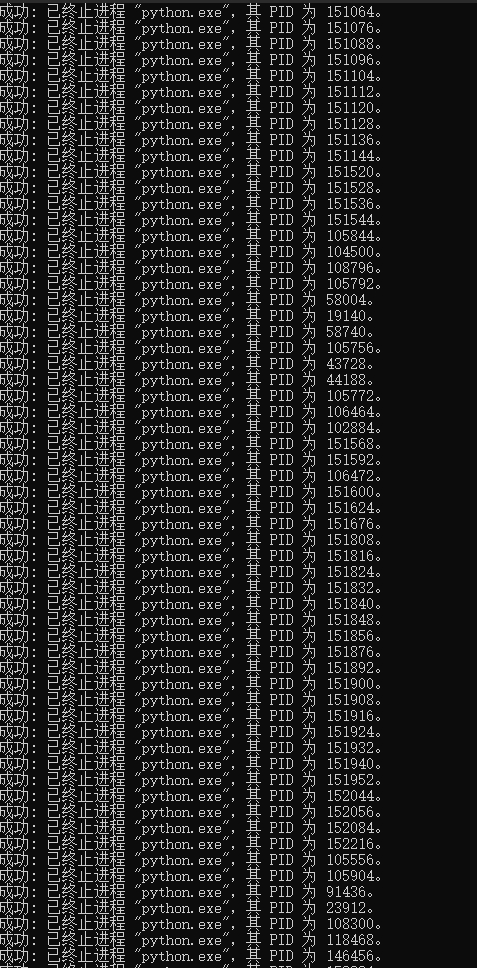

In [9]:
import os
os.system("python async_setps/demo2.py") # 输出的错误码

0

In [10]:
import subprocess 
result = subprocess.check_output(f"python {os.getcwd()}/async_setps/demo2.py")
print(result.decode())

b'HTTP/1.0 400 Bad Request\r\nContent-Type: text/html\r\nContent-Length: 349\r\nConnection: close\r\nDate: Wed, 29 Jun 2022 08:18:57 GMT\r\nServer: ECSF (sab/56E0)\r\n\r\n<?xml version="1.0" encoding="iso-8859-1"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"\n         "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">\n\t<head>\n\t\t<title>400 - Bad Request</title>\n\t</head>\n\t<body>\n\t\t<h1>400 - Bad Request</h1>\n\t</body>\n</html>\n'

sync_get cast: 1.18S



进程切换开销不止像“CPU的时间观”所列的“上下文切换”那么低。CPU从一个进程切换到另一个进程，需要把旧进程运行时的寄存器状态、内存状态全部保存好，再将另一个进程之前保存的数据恢复。对CPU来讲，几个小时就干等着。当进程数量大于CPU核心数量时，进程切换是必然需要的。

除了切换开销，多进程还有另外的缺点。一般的服务器在能够稳定运行的前提下，可以同时处理的进程数在数十个到数百个规模。如果进程数量规模更大，系统运行将不稳定，而且可用内存资源往往也会不足。

多进程解决方案在面临每天需要成百上千万次下载任务的爬虫系统，或者需要同时搞定数万并发的电商系统来说，并不适合。

除了切换开销大，以及可支持的任务规模小之外，多进程还有其他缺点，如状态共享等问题，后文会有提及，此处不再细究。

### 3.3 多线程方式

In [11]:
import time 
import socket
from concurrent.futures import ThreadPoolExecutor

def http_get(url):
    sock = socket.socket()
    sock.connect((f"{url}", 80))
    req  = f"GET / HTTP/1.0\r\n{url}\r\n\r\n"
    resp = b""
    sock.send(req.encode())
    chunk = sock.recv(4096)
    while chunk:
        resp += chunk
        chunk = sock.recv(4096)
    return resp

def sync_get():
    futures = list()
    workers = 10
    executor = ThreadPoolExecutor(workers)
    task = partial(http_get1, "example.com")
    for _ in range(workers):
        futures.append(executor.submit(task))
    
    return [f.result() for f in futures]


if __name__ == "__main__":
    begin = time.time()
    print(sync_get()[-1])
    end = time.time()
    print(f"\nsync_get cast: {round(end-begin, 2)}S")

b'HTTP/1.0 400 Bad Request\r\nContent-Type: text/html\r\nContent-Length: 349\r\nConnection: close\r\nDate: Wed, 29 Jun 2022 08:19:56 GMT\r\nServer: ECSF (sab/56BD)\r\n\r\n<?xml version="1.0" encoding="iso-8859-1"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"\n         "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">\n\t<head>\n\t\t<title>400 - Bad Request</title>\n\t</head>\n\t<body>\n\t\t<h1>400 - Bad Request</h1>\n\t</body>\n</html>\n'

sync_get cast: 0.44S


#### 比对结果

* 同步： 3.4S
* 多线程：0.39S
* 多进程：1.07S

发现进程还有线程快，那是因为电脑里开的进程多了，切换进程需要额外成本，但是`异步就是比同步快`

* 但是
> 多线程仍有问题，特别是Python里的多线程。首先，Python中的多线程因为GIL的存在，它们并不能利用CPU多核优势，一个Python进程中，只允许有一个线程处于运行状态。那为什么结果还是如预期，耗时缩减到了十分之一？

因为在做阻塞的系统调用时，例如sock.connect(),sock.recv()时，当前线程会释放GIL，让别的线程有执行机会。但是单个线程内，在阻塞调用上还是阻塞的。

> 小提示：Python中 time.sleep 是阻塞的，都知道使用它要谨慎，但在多线程编程中，time.sleep 并不会阻塞其他线程。

除了GIL之外，所有的多线程还有通病。它们是被OS调度，调度策略是抢占式的，以保证同等优先级的线程都有均等的执行机会，那带来的问题是：并不知道下一时刻是哪个线程被运行，也不知道它正要执行的代码是什么。所以就可能存在竞态条件。

例如爬虫工作线程从任务队列拿待抓取URL的时候，如果多个爬虫线程同时来取，那这个任务到底该给谁？那就需要用到“锁”或“同步队列”来保证下载任务不会被重复执行。

而且线程支持的多任务规模，在数百到数千的数量规模。在大规模的高频网络交互系统中，仍然有些吃力。当然，多线程最主要的问题还是竞态条件。


## 3.4.非阻塞（回调）
### 3.4.1 epoll
判断非阻塞调用是否就绪如果 `OS` 能做，是不是应用程序就可以不用自己去等待和判断了，就可以利用这个空闲去做其他事情以提高效率。

所以OS将`I/O状态的变化`都封装成了事件，如可`读事件`、`可写事件`。并且提供了专门的系统模块让应用程序可以`接收事件通知`。这个模块就是`select`。让应用程序可以通过`select`注册文件描述符和回调函数。当文件描述符的状态发生变化时，`select 就调用事先注册的回调函数`。

select因其算法效率比较低，后来改进成了`poll`，再后来又有进一步改进，BSD内核改进成了`kqueue`模块，而Linux内核改进成了`epoll`模块。这四个模块的作用都相同，暴露给程序员使用的API也几乎一致，区别在于kqueue 和 epoll 在处理大量文件描述符时效率更高。

鉴于 Linux 服务器的普遍性，以及为了追求更高效率，所以我们常常听闻被探讨的模块都是` epoll` 。

### 3.4.2 回调(Callback)
把I/O事件的等待和监听任务交给了 OS，那 OS 在知道I/O状态发生改变后（例如socket连接已建立成功可发送数据），它又怎么知道接下来该干嘛呢？`只能回调`。

需要我们将发送数据与读取数据封装成独立的函数，让`epoll`代替应用程序监听`socket`状态时，得告诉epoll：“如果socket状态变为可以往里写数据（连接建立成功了），请调用HTTP请求发送函数。如果socket 变为可以读数据了（客户端已收到响应），请调用响应处理函数。”

于是我们利用epoll结合回调机制重构代码：

> 这个写法接近kivy


In [12]:
import socket
from selectors import DefaultSelector, EVENT_READ, EVENT_WRITE


class Loop:
    selector = DefaultSelector()
    tasks = list()

    @staticmethod
    def run():
        while Loop.tasks:
            for event_key, event_mask in Loop.selector.select():
                callback = event_key.data
                callback(event_key, event_mask)


class Downloader:

    def __init__(self, url):
        self.url = url
        self.sock: socket.socket = None
        self.resp = B""
        Loop.tasks.append(url)

    def fetch(self):
        self.sock = socket.socket()
        self.sock.setblocking(False)
        try:
            self.sock.connect(("excample.com", 80))
        except BlockingIOError:
            pass
        Loop.selector.register(self.sock.fileno(), EVENT_WRITE, self.connected)

    def connected(self, key, mask):
        print(f"write:{self.url}")
        Loop.selector.unregister(key.fd)
        get = f"GET {self.url} HTTP/1.0\r\nHost: example.com\r\n\r\n"
        self.sock.send(get.encode())
        Loop.selector.register(key.fd, EVENT_READ, self.read_response)

    def read_response(self, key, mask):
        print(f"read:{self.url}")
        chunk = self.sock.recv(4096)
        if chunk:
            self.resp += chunk
        else:
            Loop.selector.unregister(key.fd)
            Loop.tasks.remove(self.url)


if __name__ == "__main__":
    import time
    begin = time.time()
    for i in range(10):
        d = Downloader(f"/{i}")
        d.fetch()
    Loop.run()
    end = time.time()
    print(f"\nepoll_get cast: {round(end-begin, 2)}S")

write:/1
write:/0
write:/4
write:/2
write:/5
write:/3
write:/8
write:/6
write:/7
write:/9
read:/2
read:/1
read:/3
read:/0
read:/2
read:/8
read:/4
read:/6
read:/5
read:/7
read:/1
read:/3
read:/0
read:/8
read:/4
read:/6
read:/5
read:/7
read:/9
read:/9

epoll_get cast: 0.82S


此处和前面稍有不同的是，我们将下载不同的10个页面，相对URL路径动态传入的。现在看看改进在哪。

首先，不断尝试send() 和 recv() 的两个循环被消灭掉了。

其次，导入了selectors模块，并创建了一个`DefaultSelector `实例。Python标准库提供的selectors模块是对底层select/poll/epoll/kqueue的封装。DefaultSelector类会根据 `OS 环境自动选择最佳的模块`，那在 Linux 2.5.44 及更新的版本上都是epoll了。

然后，分别注册了socket`可写事件(EVENT_WRITE)`和`可读事件(EVENT_READ)`发生后应该采取的回调函数。代码结构清晰了，阻塞操作也交给`OS去等待和通知`了


* 问题
> 我们要抓取10个不同页面，就得创建10个Crawler实例，就有20个事件将要发生，那如何从selector里获取当前正发生的事件，并且得到对应的回调函数去执行呢？


### 3.5.3 事件循环（Event Loop）


为了解决上述问题，那我们只得采用老办法，写一个循环，去访问selector模块，等待它告诉我们当前是哪个事件发生了，应该对应哪个回调。

`这个等待事件通知的循环，称之为事件循环EventLoop`。

In [2]:
    @staticmethod
    def run():
        while Loop.tasks:
            for event_key, event_mask in Loop.selector.select():
                callback = event_key.data
                callback(event_key, event_mask)

上述代码中，我们用`Loop.tasks`变量控制事件循环何时停止。当Loop.tasks 消耗完毕后会结束循环

selector.select() 是一个阻塞调用，因为如果事件不发生，那应用程序就没事件可处理，所以就干脆阻塞在这里等待事件发生。那可以推断，如果只下载一篇网页，一定要connect()之后才能send()继而recv()，那它的效率和阻塞的方式是一样的。
因为不在connect()/recv()上阻塞，也得在select()上阻塞。


所以，`selector`机制(后文以此称呼代指`epoll`/kqueue)是设计用来解决大量并发连接的。当系统中有大量非阻塞调用，能随时产生事件的时候，selector机制才能发挥最大的威力。


In [7]:
if __name__ == "__main__":
    import time
    begin = time.time()
    for i in range(10):
        d = Downloader(f"/{i}")
        d.fetch()
    Loop.run()
    end = time.time()
    print(f"\nepoll_get cast: {round(end-begin, 2)}S")


epoll_get cast: 0.54S


上述执行结果令人振奋。在单线程内用 事件循环+回调 搞定了10篇网页同时下载的问题。这，已经是异步编程了。虽然有一个for 循环顺序地创建`Download` 实例并调用`fetch` 方法添加到任务列表，但是fetch 内仅有connect()和注册可写事件，而且从执行时间明显可以推断，多个下载任务确实在同时进行！

上述代码异步执行的过程：

* 创建`Download`实例；
* 调用`fetch`方法，会创建socket连接和在selector上注册`可写`事件；
* fetch内并无阻塞操作，该方法立即返回；
* 重复上述3个步骤，将10个不同的下载任务都加入事件循环；
* 启动事件循环，进入第1轮循环，阻塞在事件监听上；
* 当某个下载任务`EVENT_WRITE`被触发，回调其connected方法，第一轮事件循环结束；
* 进入第2轮事件循环，当某个下载任务有事件触发，执行其回调函数；此时已经不能推测是哪个事件发生，因为有可能是上次connected里的`EVENT_READ`先被触发，也可能是其他某个任务的`EVENT_WRITE`被触发；（此时，原来在一个下载任务上会阻塞的那段时间被利用起来执行另一个下载任务了）
* 循环往复，直至所有下载任务被处理完成后从循环删除
* 退出事件循环，结束整个下载程序


### 3.5.4 总结
目前为止，我们已经从同步阻塞学习到了异步非阻塞。掌握了在`单线程`内同时`并发`执行多个网络I/O阻塞型任务的黑魔法。

而且与多线程相比，连线程切换都没有了，执行回调函数是函数调用开销，在线程的栈内完成，因此性能也更好，单机支持的任务规模也变成了数万到数十万个。（不过我们知道：没有免费午餐，也没有银弹。）

部分编程语言中，对异步编程的支持就止步于此（不含语言官方之外的扩展）。 

> 比如C语言, 需要程序猿自己使用epoll去注册事件和回调、维护一个事件循环，然后大多数时间都花在设计回调函数上。

通过本节的学习，我们应该认识到，不论什么编程语言，但凡要做异步编程，上述的`“事件循环+回调”`这种模式是逃不掉的，尽管它可能用的不是epoll，也可能不是while循环。

如果你找到了一种不属于` “等会儿告诉你”` 模型的异步方式，请立即给我打电话（注意，打电话是Call）。

为什么我们在某些异步编程中并没有看到 CallBack 模式呢？这就是我们接下来要探讨的问题。本节是学习异步编程的一个终点，也是另一个起点。

毕竟咱们讲 Python 异步编程，还没提到其主角协程的用武之地。


## 4 Python 对异步I/O的优化之路
我们将在本节学习到 Python 生态对异步编程的支持是如何继承前文所述的`“事件循环+回调”`模式演变到`asyncio的原生协程模式`。

### 4.1 回调之痛，以终为始
在第3节中，我们已经学会了`“事件循环+回调”`的基本运行原理，可以基于这种方式在`单线程`内实现异步编程。也确实能够大大提高程序运行效率。但是，刚才所学的只是最基本的，然而在生产项目中，要应对的复杂度会大大增加。考虑如下问题：

* 如果回调函数执行不正常该如何？ `比如崩溃、阻塞等`
* 如果回调里面还要嵌套回调怎么办？要嵌套很多层怎么办？ 可能存在`循环引用`内存泄漏
* 如果嵌套了多层，其中某个环节出错了会造成什么后果？ `异常不好管理`
* 如果有个数据需要被每个回调都处理怎么办？ 


在实际编程中，上述系列问题`不可避免`。在这些问题的背后隐藏着`回调编程模式的一些缺点`：


#### 缺点1：回调层次过多时代码`可读性差`

In [ ]:
def callback_1():
  # processing ...
  def callback_2():
      # processing.....
      def callback_3():
          # processing ....
          def callback_4():
              # processing .....
              def callback_5():
                  # processing ......
              async_function(callback_5)
          async_function(callback_4)
      async_function(callback_3)
  async_function(callback_2)
async_function(callback_1)

#### 缺点2： 破坏代码的结构性

我们有下面几个函数处理流程，假设他们处理过程都是对前面流程的依赖， 分别使用`同步`和`异步`两种写法:

In [14]:
def fun_a(r):
    return r+1
  
def fun_b(r):
    return r + 2

def fun_c(r):
    return r + 3

def fun_d(r):
    return r + 4

def fun_e(r):
    return r + 5

def fun_f(r):
    return r + 6

同步调用

In [15]:
r = fun_a(1) 
r = fun_b(r)
r = fun_c(r)
r = fun_d(r)
r = fun_e(r)
r = fun_f(r)
print(r)

22


In [ ]:
异步调用

如果 b 处理依赖于a处理的结果，而 a 过程是异步调用，就不知 a 何时能返回值，需要将后续的处理过程以`callback`的方式传递给 a， 让 a 执行完以后可以执行 b。代码变化为：

In [17]:
def fun_a1(r, callbak):
    return callbak(r+1)
  
def fun_b1(r, callbak):
    return callbak(r + 2)

def fun_c1(r, callbak):
    return callbak( r + 3)

def fun_d1(r, callbak):
    return callbak( r + 4)

def fun_e1(r, callbak):
    return callbak( r + 5)

def fun_f1(r, callbak):
    return callbak( r + 6)

In [18]:
from functools import partial

r = fun_a1(1, partial(fun_b1, callbak=partial(fun_c1, callbak=partial(fun_d1, callbak=partial(fun_e1, callbak=partial(fun_f1, callbak=print))))))

r = fun_f1(fun_e1(fun_d1(fun_c1(fun_b1(fun_a1(1, lambda x: x), lambda x: x), lambda x: x), lambda x: x), lambda x: x), print)

22
22


上面实际也是回调地狱式的风格，但这不是主要矛盾。主要矛盾在于，原本从上而下的代码结构，要改成从内到外的。先f，再e，再d，.....，直到最外层 a 执行完成。

在同步版本中，执行完a后执行b，这是线程的指令指针控制着的流程, 也符合人脑思维，而在回调版本中，流程就是程序猿需要注意和安排的。

#### 缺点3：共享状态管理困难
回顾第3节下载代码，同步阻塞版的sock对象从头使用到尾（这个还好），但是在回调的版本中，我们必须在Download实例化后的对象self里保存它自己的sock对象。如果不是采用OOP的编程风格，那需要把要共享的状态接力似的传递给每一个回调。多个异步调用之间，到底要共享哪些状态，事先就得考虑清楚，精心设计。

> 例如：ＣＰＯＳ里的支付状态很难管理

#### 缺点4: 错误处理困难
一连串的回调构成一个完整的调用链。例如上述的 a 到 f。假如 d 抛了异常怎么办？整个调用链断掉，接力传递的状态也会丢失，这种现象称为`调用栈撕裂`。 c 不知道该干嘛，继续异常，然后是 b 异常，接着 a 异常。

好嘛，报错日志就告诉你，a 调用出错了，但实际是 d 出错。

> 所以，为了防止栈撕裂，`异常必须以数据的形式返回，而不是直接抛出异常`，然后每个回调中需要检查上次调用的返回值，以防错误吞没


如果说代码风格难看是小事，但`栈撕裂`和`状态管理`困难这两个缺点会让基于回调的异步编程很艰难。
所以不同编程语言的生态都在致力于解决这个问题。才诞生了后来的`Promise`、`Co-routine`等解决方案。

Python 生态也以终为始，秉承着`“程序猿不必难程序猿”`的原则（人生苦短我用python），让语言和框架开发者苦逼一点，也要让应用开发者舒坦。

在`事件循环+回调`的基础上衍生出了基于协程的解决方案，Python2.0年代代表作有 `Tornado`、`Twisted`、`asyncio` 等。接下来我们随着 Python 生态异步编程的发展过程，深入理解Python异步编程。


> 早期的豆瓣用的就是Tornado， 会Tornado变成他们必考核的项


### 4.2 核心问题
通过前面的学习，我们清楚地认识到异步编程最大的困难：

* 异步任务何时执行完毕？
* 接下来要对异步调用的返回结果做什么操作？

上述问题我们已经通过事件循环和回调解决了。但是回调会让程序变得复杂。


`要异步，必回调`，又是否有办法规避其缺点呢？那需要弄清楚其本质，为什么回调是必须的？还有使用回调时克服的那些缺点又是为了什么？

答案是程序为了知道自己`已经`干了什么？`正在`干什么？`将来`要干什么？换言之，程序得知道当前所处的状态，而且要将这个状态在不同的回调之间延续下去。

多个回调之间的状态管理困难，那让每个回调都能管理自己的状态怎么样？链式调用会有栈撕裂的困难，让回调之间不再链式调用怎样？不链式调用的话，那又如何让被调用者知道已经完成了？那就让这个回调通知那个回调如何？而且一个回调，不就是一个待处理任务吗？

任务之间得相互通知，每个任务得有自己的状态。那不就是很古老的编程技法：协作式多任务？然而要在单线程内做调度，啊哈，`协程！`每个协程具有自己的栈帧，当然能知道自己处于什么状态，`协程之间可以协作那自然可以通知别的协程`。


#### 协程(Co-routine)

即是协作式的例程。
它是`非抢占式`的多任务子例程的概括，可以允许有`多个入口`点在例程中确定的位置来控制程序的`暂停`与`恢复`执行。没事就主动让出CPU

例程是什么？编程语言定义的可被调用的代码段，为了完成某个特定功能而封装在一起的一系列指令。一般的编程语言都用称为函数或方法的代码结构来体现。


### 4.4 基于生成器的协程
早期的 Pythoner 发现 Python 中有种特殊的对象——`生成器（Generator）`，它的特点和协程很像。每一次迭代之间，会`暂停执行`，继续下一次迭代的时候还`不会丢失先前的状态`。

为了支持用生成器做简单的协程，Python 2.5 对生成器进行了增强(PEP 342)，该增强提案的标题是` “Coroutines via Enhanced Generators”`。有了PEP 342的加持，生成器可以通过`yield 暂停`执行和向外`返回数据`，也可以通过`send()`向生成器内`发送数据`，还可以通过`throw()`向生成器内`抛出异常`以便随时终止生成器的运行。


In [19]:
def avg():
    total, cnt = 0, 1
    while True:
        print("step1")
        n = yield total / cnt
        print("step2")
        cnt += 1
        total += n
avg()

<generator object avg at 0x08EF9258>

In [20]:
def get_avg(n):
    g = avg() 
    # 激活
    print(g.send(None))
    # 取值
    return g.send(n)

print(get_avg(10))

step1
0.0
step2
step1
5.0


In [ ]:
如何生成器退出了？

In [84]:
def fun():
    yield 124

print(fun())
g = fun()
g.send(None)

try:
    g.send(None)
except StopIteration:
    print("fun() exit")


<generator object fun at 0x0610E5A0>
fun() exit


当生成器抛出`StopIteration` 时候就说明是停止状态。接下来，我们用基于生成器的协程来重构先前的下载器代码。

`yield ` 的作用有：
* 把外面send()的值传给n;
* 把total / cnt 的值返回给send()
* 暂停在print("step2")之前

#### 4.4.1 未来对象(Future)
不用回调的方式了，怎么知道异步调用的结果呢？先设计一个对象，异步调用执行完的时候，就把结果放在它里面。这种对象称之为`未来对象`。

In [123]:
import socket
from selectors import DefaultSelector, EVENT_WRITE, EVENT_READ

class Future:
    def __init__(self):
        self.result = None
        self._callbacks = list()

    def add_done_callback(self, fn):
        self._callbacks.append(fn)

    def set_result(self, result):
        self.result = result
        for fn in self._callbacks:
            fn(self)
            

未来对象有一个result属性，用于存放未来的执行结果。还有个set_result()方法，是用于设置result的，并且会在给result绑定值以后运行事先给future添加的回调。回调是通过未来对象的add_done_callback()方法添加的。

不要疑惑此处的callback，说好了不回调的嘛？难道忘了我们曾经说的`要异步，必回调`。不过也别急，此处的回调，和先前学到的回调，`还真有点不一样`。


### 4.4.2 使用yield重构 Download
现在不论如何，我们有了未来对象可以代表未来的值。先用`Future`来重构爬虫代码

In [124]:
class Download:
    def __init__(self, url):
        self.url = url
        self.resp = b""

    def fetch(self):
        sock = socket.socket()
        sock.setblocking(False)
        try:
            sock.connect(("excample.com", 80))
        except BlockingIOError:
            pass
        f = Future()

        def on_connected():
            f.set_result(None)

        Loop.selector.register(sock.fileno(), EVENT_WRITE, on_connected)
        yield f
        Loop.selector.unregister(sock.fileno())
        get = f"GET {self.url} HTTP/1.0\r\nHost: example.com\r\n\r\n"
        sock.send(get.encode())

        while True:
            f = Future()

            def on_readable():
                f.set_result(sock.recv(4096))

            Loop.selector.register(sock.fileno(), EVENT_READ, on_readable)
            chunk = yield f
            Loop.selector.unregister(sock.fileno())
            # print(f"reade {self.url}:{chunk}")
            if chunk:
                self.resp += chunk
                continue
            if self.url in Loop.tasks:
                Loop.tasks.remove(self.url)


和先前的回调版本对比，已经有了较大差异。

`fetch` 方法内有了`yield`表达式，使它成为了生成器。我们知道生成器需要先调用`next()`迭代一次或者是先`send(None)`启动，遇到`yield之`后便暂停。

那这`fetch`生成器如何再次恢复执行呢？

至少 `Future` 类和 `Download`类都没看到相关代码。需要其他代码来激活他，这个代码就是`Task`的工作职责


### 4.4.3 任务对象(Task)
为了解决上述问题，我们只需遵循一个`编程规则：单一职责`，每种角色各司其职，如果还有工作没有角色来做，那就创建一个角色去做。

没人来恢复这个生成器的执行么？没人来管理生成器的状态么？创建一个，就叫`Task`好了，很合适的名字。

In [125]:

class Task:
    def __init__(self, coroutine):
        self.coroutine = coroutine
        f = Future()
        f.set_result(None)
        self.step(f)

    def step(self, future):
        try:
            next_future = self.coroutine.send(future.result)
        except StopIteration:
            return
        next_future.add_done_callback(self.step)
    

* Task 类的入参是`Download.fetch()` 一个生成器
* 生成器需要预先激活所以调用了一次step()
* step做了send, 传入future的result, 第一次是None, 
* yield之前做了非阻塞连接，传进来的None fetch() 内部没有用到，只是激活，而且把`Future未来对象(连接结果)`返回给了next_futre
* `Future未来对象(连接结果)`设置了一个setp的回调
* 这个setp的回调会在`Future未来对象(连接设置结果)` 里调用，触发下一步send
* 这样形成了一个链式的`结果回调自激发下一步`的逻辑


### 4.4.4 事件循环(Event Loop)驱动协程运行
该事件循环上场了。接下来，只需等待已经注册的EVENT_WRITE事件发生。事件循环就像心脏一般，只要它开始跳动，整个程序就会持续运行。


In [127]:
class Loop:
    selector = DefaultSelector()
    tasks = list()

    @staticmethod
    def run():
        while Loop.tasks:
            for event_key, event_mask in Loop.selector.select():
                callback = event_key.data
                callback()

if __name__ == "__main__":
    import time
    begin = time.time()
    for url in range(10):
        url = f"/{url}"
        Loop.tasks.append(url)
        d = Download(url)
        Task(d.fetch())

    Loop.run()
    print(f"yield cast:{time.time() - begin}")


yield cast:0.6247143745422363


现在loop有了些许变化，callback()不再传递event_key和event_mask参数。也就是说，这里的回调根本不关心是谁触发了这个事件，结合fetch()可以知道，它只需完成对future设置结果值即可f.set_result()。而且future是谁它也不关心，因为协程能够保存自己的状态，知道自己的future是哪个。也不用关心到底要设置什么值，因为要设置什么值也是协程内安排的。

此时的`loop`，真的成了一个`心脏`，它只管往外泵血，不论这份血液是要输送给大脑还是要给脚趾，只要它还在跳动，生命就能延续。


### 4.4.5 生成器协程风格和回调风格对比总结
在回调风格中：

* 存在链式回调（虽然示例中嵌套回调只有一层）
* 请求和响应也不得不分为两个回调以至于`破坏了同步代码`那种结构
* 程序员必须在回调之间维护必须的状态。
* 还有更多示例中没有展示，但确实存在的问题，参见4.1节。

而基于生成器协程的风格：

* 无链式调用
* selector的回调里只管给future设置值，不再关心业务逻辑
* loop 内回调callback()不再关注是谁触发了事件
* 已趋近于`同步代码的结构`
* `无`需程序员在多个协程之间`维护状态`，例如哪个才是自己的sock

### 4.4.6 碉堡了，但是代码很丑！能不能重构？
如果说fetch的`容错能力`要更强，业务功能也需要更完善，怎么办？而且技术处理的部分（socket相关的）和业务处理的部分（请求与返回数据的处理）混在一起。

* 创建socket连接可以抽象复用吧？
* 循环读取整个response可以抽象复用吧？
* 循环内处理socket.recv()的可以抽象复用吧？
* 抽象后生成器调其他生成器怎么办？

但是这些关键节点的地方都有`yield`，抽离出来的那部分的复用代码也需要是生成器。而且fetch()自己也得是生成器。`生成器`里再`调用`其他`生成器`，代码好像要写得更丑才可以

Python 语言的设计者们也认识到了这个问题，再次秉承着`“程序猿不必为难程序猿”`的原则，他们捣鼓出了一个`yield from`来解决生成器调用玩生成器的问题。


## 4.5 用 yield from 改进生成器协程

### 4.5.1 yield from语法介绍
`yield from` 是Python `3.3` 新引入的语法（PEP 380）。它主要解决的就是在生成器里玩生成器不方便的问题。它有两大主要功能。

#### 第一个功能是：
让嵌套生成器不必通过循环迭代yield，而是直接yield from。以下两种在生成器里玩子生成器的方式是等价的。

```python
def gen_one():
    subgen = range(10)    
    yield from subgen

def gen_two():
    subgen = range(10)    
    for item in subgen:        
        yield item
```

#### 第二个功能就是
在子生成器和原生成器的调用者之间`打开双向通道`，两者可以直接通信。

In [140]:
def gen():
    print("step2")
    
    # 这里会也会向subgen生成器send(None) 激活
    r = yield from subgen()
    
    # yield from 是直到subgen 返回或者 StopIteration 异常才往下运行
    # r 是subgen第二次返回的1, 并不是第一次的2
    r += 3
    print(f"step7:{r}")
    return r


def subgen():
    print(f"step3")
    x = yield
    # x 的值是1，是gen() 转过来的值
    print(f"step5:{x}")
    
    # 这里返回1 + 1
    yield x+1  
    
    # 这里是下次send() 才执行， 此时x是1
    return x


def main():
    print("step0")
    g = gen()
    print(f"step1 gen type:{g}")
    next(g)                     # 驱动生成器g开始执行到第一个 yield
    print("step4")
    result = g.send(1)          # 看似向生成器 gen() 发送数据， 并且转到subgen
    print("step6", result)      # 返回2是 subgen 里的第一个yield结果
    print("step8", g.send(10))  # 这里的10 subgen 并没有使用，因为已经没有yield语句了，抛StopIteration
    # g.throw(StopIteration)    # 看似向gen()抛入异常

main()



step0
step1 gen type:<generator object gen at 0x06CB1920>
step2
step3
step4
step5:1
step6 2
step7:4


StopIteration: 4

从上面的代码运行结果可以看出来，`yield from` 是连接两个生成器的`双向管道通信管道`。有几点需要注意以下：
* yield form 一个子生成器是时候，不会运行它下面的代码，直到子生成器退出为止`return` 或者抛`StopIteration`
* yield form 会传递父级send的值给子生成器
* yield form 收到子生成器的值也会直接传递给父级


### 4.5.2 使用yield from重构代码
抽象socket连接的功能:


In [167]:
def connect(sock, host):
    f = Future()
    sock.setblocking(False)
    try:
        sock.connect(host)
    except BlockingIOError:
        pass
    
    def on_connected():
        f.set_result(None)
        
    Loop.selector.register(sock.fileno(), EVENT_WRITE, on_connected)
    
    # feach 传递这里
    yield from f
    Loop.selector.unregister(sock.fileno())


抽象单次接收和读取完整的response功能：

In [174]:
def read(sock):
    f = Future()
    
    def on_readable():
        f.set_result(sock.recv(4096))
        
    Loop.selector.register(sock.fileno(), EVENT_READ, on_readable)
    chunk = yield from f
    Loop.selector.unregister(sock.fileno())
    return chunk

def read_all(sock):
    resp = b""
    chunk = yield from read(sock)
    while chunk:
        resp += chunk
        chunk = yield from read(sock)

最后完成`Download`类的重构

In [181]:
import socket 

class Download:
    def __init__(self, url):
        self.url = url
        self.resp = b""
        
    def fetch(self):
        sock = socket.socket()
        sock.setblocking(False)
        # 激活传递到子生成器
        yield from connect(sock, ("example.com", 80))
        get = f"GET {self.url} HTTP/1.0\r\nHost: example.com\r\n\r\n"
        sock.send(get.encode())
        self.resp = yield from read_all(sock)
        if self.url in Loop.tasks:
            Loop.tasks.remove(self.url)

`Future` 类增加了迭代方法，他内部也用了`yield` 所以也变成了`生成器`，变成可被`yield from等待的对象`

In [184]:
import socket
from selectors import DefaultSelector, EVENT_WRITE, EVENT_READ

class Task:
    def __init__(self, coroutine):
        self.coroutine = coroutine
        f = Future()
        f.set_result(None)
        self.step(f)

    def step(self, future):
        try:
            next_future = self.coroutine.send(future.result)
        except StopIteration:
            return
        next_future.add_done_callback(self.step)
        
        
class Future:
    def __init__(self):
        self.result = None
        self._callbacks = list()

    def add_done_callback(self, fn):
        self._callbacks.append(fn)

    def set_result(self, result):
        self.result = result
        for fn in self._callbacks:
            fn(self)
            
    def __iter__(self):
        yield self
        return self.result

In [ ]:
Loop 跟以前一样

In [183]:
class Loop:
    selector = DefaultSelector()
    tasks = list()

    @staticmethod
    def run():
        while Loop.tasks:
            for event_key, event_mask in Loop.selector.select():
                callback = event_key.data
                callback()

if __name__ == "__main__":
    import time
    begin = time.time()
    for url in range(10):
        url = f"/{url}"
        Loop.tasks.append(url)
        d = Download(url)
        
        # 生成传入task内部会激活
        Task(d.fetch())

    Loop.run()
    print(f"yield from cast:{time.time() - begin}")

yield from cast:0.48593711853027344


执行步骤：
* 实例化Download(url)得到包含`生成器`对象
* 实例化Task(d.fetch()) 把生成器传到`任务`内部
* `Task任务`内部会进行一次step()`激活send`到fetch，触发连接请求然后`暂停`，并且把自己(step函数注册到Futre回调里)，等待连接完成。
* 当连接时候触发on_connected回调，set_result设置`Future` 再次触发step, connect 内部的`yield from`完成, 继续向下执行，取消连接事件回调注册，connect真正的return
* 回到fetch内部，发送sock.send(get.encode()) GET请求数据
* yield from read_all() 激活传递到read(), 内部等待数据接收事件
* on_readable 回到set_result设置`Future` 再次触发step, read 内部的`yield from`完成, 继续向下执行，取消连接事件回调注册，read真正的return
* 回到read_all的循环，如果数据是空的那return， 
* 回到yield from read_all()下面部分的代码，完成一次请求和接收的流程
* 把url 从tasks里移除


目的是达到了，`Future`变成可迭代`iterable`的对象，如果不把Future改成iterable也是可以的，还是用原来的yield f即可。那为什么需要改进呢？

* 首先, 我们是在基于生成器做协程，而生成器还得是生成器，如果继续混用`yield`和`yield from` 做协程，代码可读性和可理解性都不好。
* 其次，如果不改，协程内还得关心它等待的对象是否可被yield，如果协程里还想继续返回协程怎么办？如果想调用普通函数动态生成一个Future对象再返回怎么办？

所以，在Python 3.3 引入yield from新语法之后，就不再推荐用yield去做协程。全都使用yield from由于其双向通道的功能，可以让我们在协程间随心所欲地传递数据。



### .5.3 yield from改进协程总结
用`yield from`改进基于生成器的协程，代码抽象程度更高。使业务逻辑相关的代码更精简。由于其双向通道功能可以让协程之间随心所欲传递数据，使Python异步编程的协程解决方案大大向前迈进了一步。

于是Python语言开发者们充分利用`yield from`，使 Guido 主导的Python异步编程框架Tulip迅速脱胎换骨，并迫不及待得让它在 `Python 3.4` 中换了个名字`asyncio`以`“实习生”`角色出现在标准库中。

### 4.5.4 asyncio 介绍
`asyncio`是`Python 3.4` 试验性引入的异步I/O框架（PEP 3156），提供了基于`协程做异步I/O编写单线程并发`代码的基础设施。其核心组件`有事件循环（Event Loop）`、`协程(Coroutine）`、`任务(Task)`、`未来对象(Future)`以及其他一些扩充和辅助性质的模块。

在引入asyncio的时候，还提供了一个装饰器`@asyncio.coroutine`用于装饰使用了`yield from`的函数，以标`记其为协程`。但并不强制使用这个装饰器。

虽然发展到 Python 3.4 时有了`yield from`的加持让协程更容易了，但是由于协程在Python中发展的历史包袱所致，很多人仍然弄不明白生成器和协程的联系与区别，也弄不明白`yield`和 `yield from` 的区别。这种混乱的状态也违背Python之禅的一些准则。

于是Python设计者们又快马加鞭地在 `3.5` 中新增了`async/await`语法（PEP 492），对协程有了明确而显式的支持，称之为`原生协程`。`async/await` 和 `yield from`这两种风格的协程底层复用共同的实现，而且相互兼容。

在Python 3.6 中asyncio库`“转正”`，不再是实验性质的，成为标准库的正式一员。

> 可以去github 翻阅很多异步比如类似FastApi, sanic这样的框架都是要求python3.6 以上， 这就是因为他们内部使用了`async/await`转正以后的语法原因



### 4.6 总结
行至此处，我们已经掌握了asyncio的核心原理：

#### 利用`yield 和 `yield from` 可暂停/恢复函数，可传参/可返值的双向通信原理，配合事件回调Loop、未来对象Future和巧妙的Task, 形成了链式自己激活的生成器式协程

学习了它的原型，也学习了异步I/O在 CPython 官方支持的生态下是如何一步步发展至今的。

实际上，真正的asyncio比我们前几节中学到的要复杂得多，它还实现了零拷贝、公平调度、异常处理、任务状态管理等等使 Python 异步编程更完善的内容。理解原理和原型对我们后续学习有莫大的帮助。

在python3.4 以前的asyncio 是使用pthon实现的，在python3.5 之后使用去实现提高了性能。


## 5 使用asyncio原生协程重构
本节中，我们将初步体验asyncio库和新增语法async/await给我们带来的便利。由于Python2-3的过度期间，Python3.0-3.4的使用者并不是太多，也为了不让更多的人困惑，也因为aysncio在3.6才转正，所以更深入学习asyncio库的时候我们将使用async/await定义的原生协程风格，yield from风格的协程不再阐述（实际上它们可用很小的代价相互代替）。


In [207]:
import aiohttp
import asyncio
host = "http://example.com"

async def fetch(url):
    async with aiohttp.ClientSession() as s:
        async with s.get(url) as resp:
            return await resp.read()
        
if __name__ == "__main__":
    import time
    begin = time.time()
    tasks = [fetch(f"{host}/url") for url in range(10)]
    # asyncio.run(asyncio.gather(*tasks))
    await asyncio.gather(*tasks)
    print(f"asyncio cast:{time.time()-begin}")

asyncio cast:0.47393012046813965


对比生成器版的协程，使用asyncio库后变化很大：

* 没有了yield 或 yield from，而是async/await
* 没有了自造的loop()，取而代之的是asyncio.get_event_loop()
* 无需自己在socket上做异步操作，不用显式地注册和注销事件，aiohttp库已经代劳
* 没有了显式的** Future** 和** Task，asyncio**已封装
* 更少量的代码，更优雅的设计

说明：我们这里发送和接收HTTP请求不再自己操作socket的原因是，在实际做业务项目的过程中，要处理妥善地HTTP协议会很复杂，我们需要的是功能完善的异步HTTP客户端，业界已经有了成熟的解决方案，DRY不是吗？

和同步阻塞版的代码对比：

* 异步化
* 代码量相当（引入aiohttp框架后更少）
* 代码逻辑同样简单，跟同步代码一样的结构、一样的逻辑
* 接近10倍的性能提升

### 总结
到此为止，我们已经深入地学习了异步编程`是什么`、`为什么`、在Python里是`怎么样发展`的。我们找到了一种让代码看起来跟同步代码一样简单，而效率却提升N倍（具体提升情况取决于项目规模、网络环境、实现细节）的异步编程方法。它也没有回调的那些缺点。

问题： 如果代码都是异步的结构，移到同步的调用如何处理？




## 6 在Kivy 使用asyncio
kivy 只提供了启动APP的协程，但是内部代码都是同步的，那是不是kivy 就是一个伪异步呢？在kivy如果写原生的异步代码？我们先看看同步阻塞怎么写的：


In [1]:
import functools
import time

from kivy.app import App
from kivy.core.window import Window
from kivy.uix.button import Button
import asyncio
import requests


class MyButton(Button):
    http_task = None

    def data_from_http(self, url):
        r = requests.get(url)
        print(f"r.status:{r.status_code}")
        if r.status_code == 200:
            return "hell OK"
        else:
            return "hello Error"

    def on_press(self):
        print("MyButton on_press")
        self.text = self.data_from_http("https://www.example.com")
        time.sleep(2)
        Window.on_close()


class MyApp(App):
    def build(self):
        return MyButton(text="hello")


MyApp().run()


[INFO   ] [Logger      ] Record log in C:\Users\guanglin.liang\.kivy\logs\kivy_22-06-29_2.txt
[INFO   ] [deps        ] Successfully imported "kivy_deps.angle" 0.3.2
[INFO   ] [deps        ] Successfully imported "kivy_deps.glew" 0.3.1
[INFO   ] [deps        ] Successfully imported "kivy_deps.sdl2" 0.3.1
[INFO   ] [Kivy        ] v2.0.0
[INFO   ] [Kivy        ] Installed at "d:\program files (x86)\python38-32\lib\site-packages\kivy\__init__.py"
[INFO   ] [Python      ] v3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:34:34) [MSC v.1928 32 bit (Intel)]
[INFO   ] [Python      ] Interpreter at "d:\program files (x86)\python38-32\python.exe"
[INFO   ] [Factory     ] 186 symbols loaded
[INFO   ] [Image       ] Providers: img_tex, img_dds, img_sdl2, img_pil (img_ffpyplayer ignored)
[INFO   ] [Window      ] Provider: sdl2
[INFO   ] [GL          ] Using the "OpenGL" graphics system
[INFO   ] [GL          ] GLEW initialization succeeded
[INFO   ] [GL          ] Backend used <glew>
[INFO   ] [GL    

MyButton on_press
r.status:200


[ERROR  ] [Base        ] No event listeners have been created
[ERROR  ] [Base        ] Application will leave
[INFO   ] [Base        ] Start application main loop
[ERROR  ] [Base        ] No event listeners have been created
[ERROR  ] [Base        ] Application will leave
[INFO   ] [Base        ] Leaving application in progress...
[INFO   ] [Base        ] Leaving application in progress...
[INFO   ] [Base        ] Start application main loop
[ERROR  ] [Base        ] No event listeners have been created
[ERROR  ] [Base        ] Application will leave
[INFO   ] [Base        ] Leaving application in progress...
[INFO   ] [Base        ] Leaving application in progress...


再看使用异步的写法

In [4]:
from kivy.app import App
from kivy.uix.button import Button
import asyncio
import aiohttp


class MyButton(Button):
    http_task = None

    async def http_get(self):
        s = aiohttp.ClientSession()
        r = await s.get("https://www.example.com")
        self.text = self.text + f" {r.status}"

    def on_press(self):
        print("MyButton on_press")
        self.http_task and self.http_task.cancel()
        self.http_task = asyncio.create_task(self.http_get())


class MyApp(App):
    def build(self):
        return MyButton(text="hello")


asyncio.run(MyApp().async_run())


下面是再kivy 里调用了同步阻塞库requests的处理

In [23]:
import functools
import time

from kivy.app import App
from kivy.uix.button import Button
import asyncio
import requests

class MyButton(Button):
    http_task = None

    def http_get(self, url):
        time.sleep(10)
        return requests.get(url)

    async def update_txt(self):
        loop = asyncio.get_event_loop()
        # r = await loop.run_in_executor(None, requests.get, "https://www.baidu.com")
        r = await loop.run_in_executor(None, self.http_get, "https://www.baidu.com")
        print(f"r.status:{r.status_code}")
        if r.status_code == 200:
            self.text = "hell OK"
        else:
            self.text = "hello Error"

    def on_press(self):
        print("MyButton on_press")
        loop = asyncio.get_event_loop()
        loop.create_task(self.update_txt())


class MyApp(App):
    def build(self):
        return MyButton(text="hello")


# asyncio.run(MyApp().async_run())
await MyApp().async_run()


ArgumentError: argument 3: <class 'TypeError'>: wrong type

这为了模拟一个夸张的get请求，封装一个10S 的请求http_get, 发现这个过程连点击button 并没有阻塞，这是因为`loop.run_in_executor` 把他挪到线程池里面运行了
那为什么Kivy内部 也是同步代码，为什么kivy 不用run_in_executor， 那是因为kivy 代码本身都是cpu型代码，也就是说kivy 只有用到了贴图渲染相关的代码，剩下的都交给了GPU.
而强CPU类型的计算使用了cython 来加速，所以不要再kivy代码里做io阻塞的代码


## 结语：
python 转正后的原生async/await 接近了异步难、异步回调、同步混合代码的问题，使得工程项目中可以普及异步更为容易

[awesome-asyncio](https://github.com/timofurrer/awesome-asyncio)